# CASE STUDY: SALIFORT MOTORS EMPLOYEES RETENTION RATE

## ABOUT THE COMPANY
Salifort Motors is a fictional French-based alternative energy vehicle manufacturer. Its global workforce of over 100,000 employees research, design, construct, validate, and distribute electric, solar, algae, and hydrogen-based vehicles. Salifort’s end-to-end vertical integration model has made it a global leader at the intersection of alternative energy and automobiles.        

As a data specialist working for Salifort Motors, I have received the results of a recent employee survey. The senior leadership team has tasked me with analyzing the data to come up with ideas for how to increase employee retention. To help with this, they would like me to design a model that predicts whether an employee will leave the company based on their  department, number of projects, average monthly hours, and any other data points I deem helpful. 

## **PLAN**

**OBJECTIVE:**
- decrease employee turnover rate to reduce cost incurred in new candidates selections and training in order to replace empty positions

**HOW:**
- using available employees data to find out the main drivers to higher possibility of resignation

## **ANALYSE**

### ***AVAILABLE DATASET COLUMNS***

| Variable              | Description                                                        |
|-----------------------|--------------------------------------------------------------------|
| satisfaction_level    | Employee-reported job satisfaction level [0–1]                     |
| last_evaluation       | Score of employee's last performance review [0–1]                  |
| number_project        | Number of projects employee contributes to                         |
| average_monthly_hours | Average number of hours employee worked per month                  |
| time_spend_company    | How long the employee has been with the company (years)            |
| Work_accident         | Whether or not the employee experienced an accident while at work  |
| promotion_last_5years | Whether or not the employee was promoted in the last 5 years       |
| department            | The employee's department                                          |
| left  ***<---target***| Whether or not the employee left the company                       |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_curve, auc, average_precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree

from xgboost import XGBClassifier
from xgboost import plot_importance

pd.set_option.display_max_columns = None

In [2]:
df = pd.read_csv('HR_comma_sep.csv')

In [3]:
len(df)

14999

In [4]:
df.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


In [5]:
df.rename(columns={'Work_accident': 'work_accident', 'Department':'department', 'average_montly_hours': 'average_monthly_hours'}, inplace=True)

In [6]:
#CHECK FOR DUPLICATE ROWS
len(df[df.duplicated()])

3008

*There isn't a unique identifier for the employees, hence it might be possible that the duplicates were actually from 2 different people, however with 10 columns, the possibility is extremely low, therefore it is better to drop them.*

In [7]:
df = df.drop_duplicates()

In [8]:
#CHEK FOR NULL CELLS
pd.isna(df).sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [9]:
#CONVERT salary VALUES TO NUMERICAL VALUES
_SALARY = {'low': 0, 'medium': 1, 'high': 2}

df['salary'] = df['salary'].map(_SALARY)

In [10]:
df['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

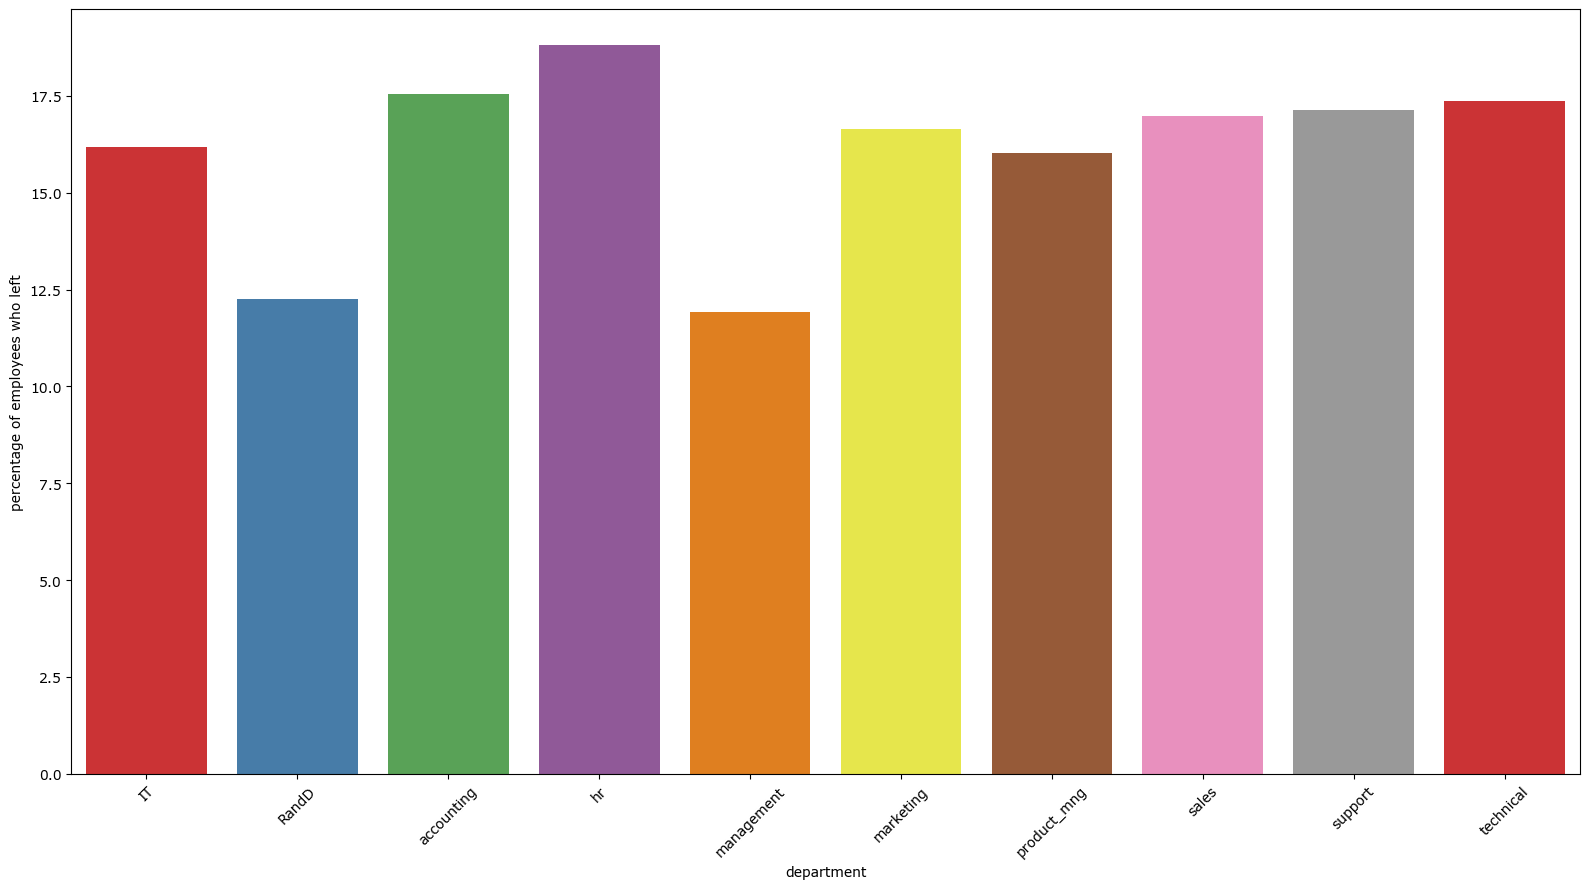

In [11]:
#CHECK IF THERE IS A DISCREPANCY BETWEEN DEPARTMENTS IN RELATION TO RETENTION RATE
left_percentages = (df.groupby('department')['left'].mean() * 100).reset_index()

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(left_percentages, y = 'left', x='department', palette='Set1')
plt.xlabel('department')
plt.ylabel('percentage of employees who left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

*As shown above, there is very small difference in the rentention between departments, except for the lower rates of management and random ones (which might also be by chance looking at the total number of employees). Hence that column can be omitted from being a feature.*

***note:*** being in which department might actually play a part, however the main factor would be out of reach from the available data, such as the simplicity of the responsibilities, or the work environment in distinct departments, etc. This can actually be looked into.

In [13]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.00000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929,0.60387
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012,0.63590
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.00000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000,0.00000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,1.00000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000,1.00000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,2.00000


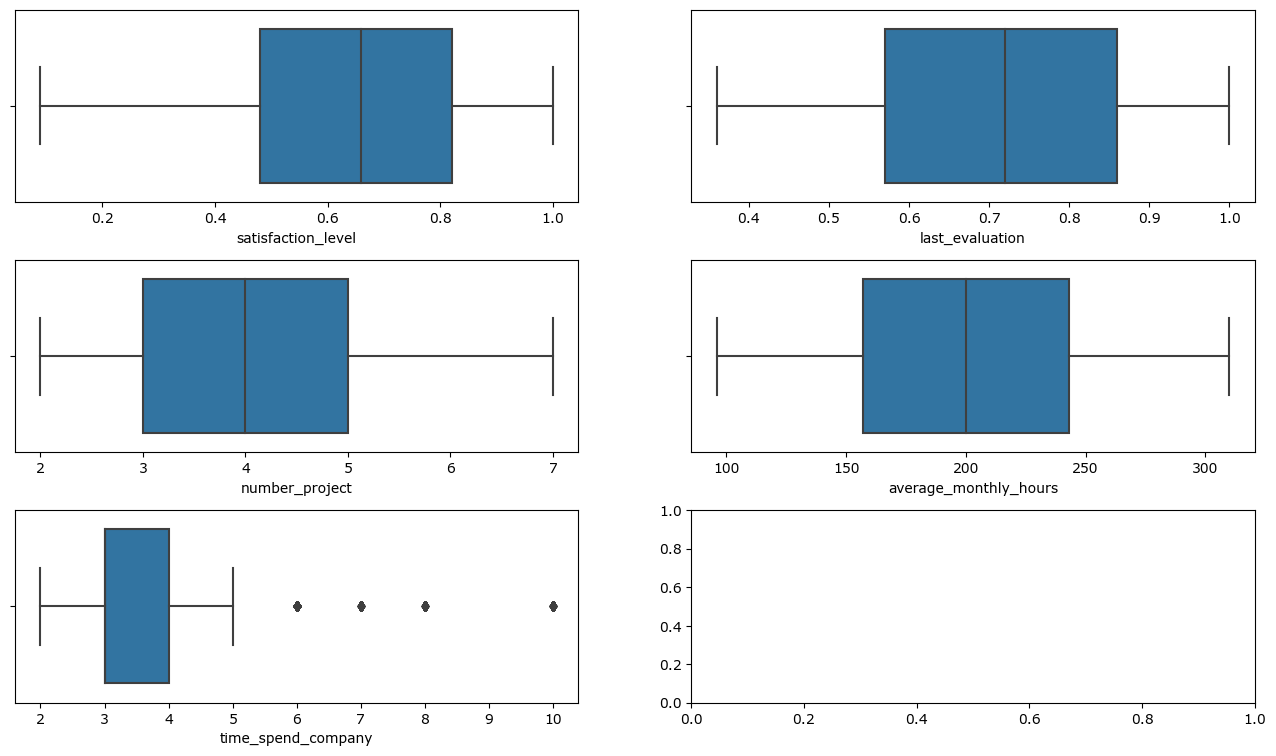

In [14]:
#CHECK FOR OUTLIERS

_BOXPLOT_COLUMNS = ['satisfaction_level', 'last_evaluation', 'number_project',
                    'average_monthly_hours', 'time_spend_company']

plt.subplots(figsize=(16,9), nrows=3, ncols=2)
plt.subplots_adjust(hspace=0.3)

for i in range(len(_BOXPLOT_COLUMNS)):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=df[_BOXPLOT_COLUMNS[i]])
    
plt.show()

In [15]:
# COMPUTE THE 25TH PERCENTILE VALUE IN time_spend_company
percentile25 = df['time_spend_company'].quantile(0.25)
print("25TH PERCENTILE:", percentile25)

# COMPUTE THE 75TH PERCENTILE VALUE IN time_spend_company
percentile75 = df['time_spend_company'].quantile(0.75)
print("75TH PERCENTILE:", percentile75)


# COMPUTE THE INTERQUARTILE RANGE IN time_spend_company
iqr = percentile75 - percentile25
print("VALUE OF IQR:", iqr)

# DEFINE THE UPPER LIMIT AND LOWER LIMIT FOR NON-OUTLIER VALUES IN time_spend_company
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("LOWER LIMIT:", lower_limit)
print("UPPER LIMIT:", upper_limit)

# IDENTIFY SUBSET OF DATA CONTAINING OUTLIERS IN time_spend_company
outliers = df[(df['time_spend_company'] > upper_limit) | (df['time_spend_company'] < lower_limit)]

# COUNT HOW MANY ROWS IN THE DATA CONTAIN OUTLIERS IN time_spend_company
print("NUMBER OF OUTLIERS:", len(outliers))

25TH PERCENTILE: 3.0
75TH PERCENTILE: 4.0
VALUE OF IQR: 1.0
LOWER LIMIT: 1.5
UPPER LIMIT: 5.5
NUMBER OF OUTLIERS: 824


C:\Users\Hush\AppData\Local\Temp\ipykernel_19304\1505363356.py:11: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



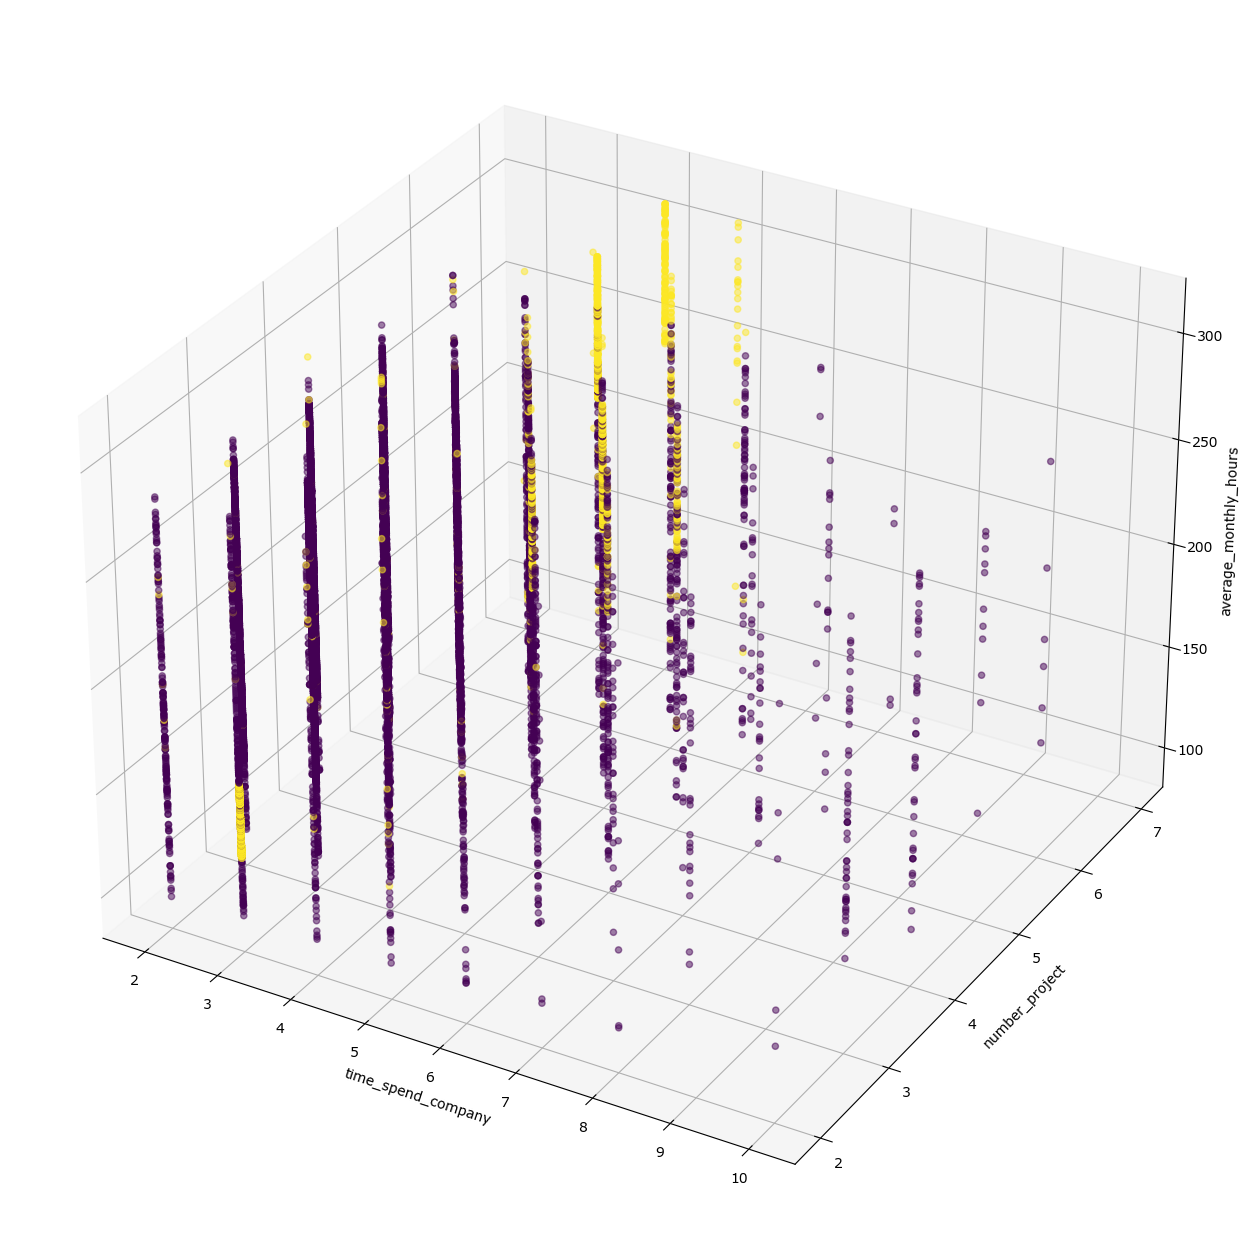

In [52]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

df_over = df[['time_spend_company', 'number_project', 'average_monthly_hours','left']].copy()


ax.scatter3D(data=df_over, xs='time_spend_company', ys='number_project', zs='average_monthly_hours', c='left', alpha=0.5)
ax.set_xlabel('time_spend_company')
ax.set_ylabel('number_project')
ax.set_zlabel('average_monthly_hours')
ax.dist = 10

plt.show()

#USE THIS FOR INTERACTIVE PLOT
# df_over = df[['time_spend_company', 'number_project', 'average_monthly_hours','left']].copy()
# df_over['left'] = df_over['left'].map({0:'no', 1:'yes'})

# fig = px.scatter_3d(df_over, x='time_spend_company', y='number_project', z='average_monthly_hours', color='left', color_discrete_map={'no': 'blue', 'yes': 'red'},
#                     width=1080, height=1080)

# fig.update_layout(scene=dict(
#     xaxis_title='time_spend_company',
#     yaxis_title='number_project',
#     zaxis_title='average_monthly_hours'
# ))

# fig.show()

*One thing that the plot above shows is that those overworked (having multiple projects done at the same time, shown by the high number of projects even though only been with the company a short time, in addition to the average number of hours put monthly), will tend to resign in the end.*

C:\Users\Hush\AppData\Local\Temp\ipykernel_19304\3714339702.py:12: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



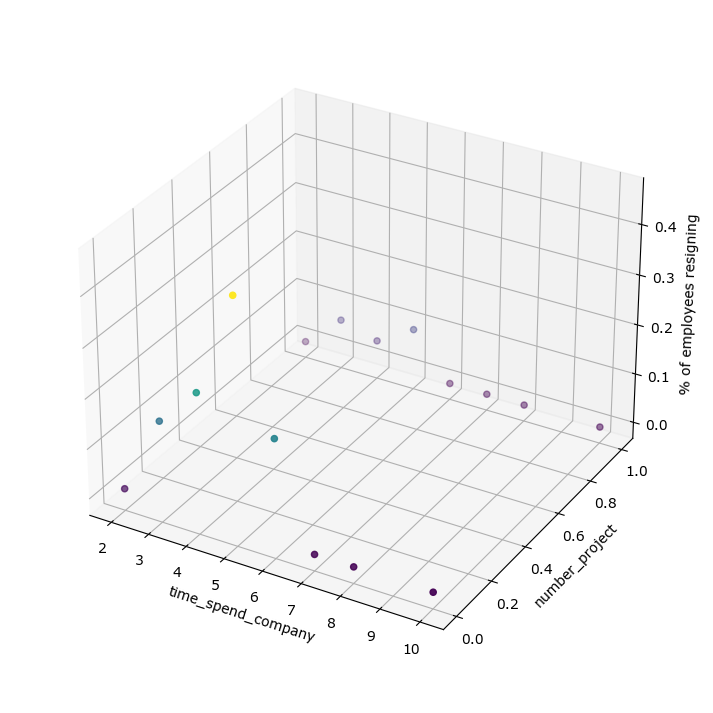

In [56]:
#CHECKING TO SEE IF THE NUMBER OF PROJECTS WORKED ON, GIVEN A SPECIFIC YEARS THE EMPLOYEE HAS BEEN IN THE COMPANY MATTERS

df_time_prom = df.groupby(['promotion_last_5years', 'time_spend_company'])['left'].mean().reset_index()

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(data=df_time_prom, xs='time_spend_company', ys='promotion_last_5years', zs='left', c='left')
ax.set_xlabel('time_spend_company')
ax.set_ylabel('number_project')
ax.set_zlabel('% of employees resigning')

ax.dist = 11

plt.show()

#USE THIS FOR INTERACTIVE PLOT
# fig = px.scatter_3d(df_time_prom, x='time_spend_company', y='promotion_last_5years', z='left',
#                     width=1080, height=1080)

# fig.update_layout(scene=dict(
#     xaxis_title='time_spend_company',
#     yaxis_title='promotion_last_5years',
#     zaxis_title='% of employees resigning'
# ))

# fig.show()


*From the plot above, we can see that those of lower positions have higher employee turnover, and this happens more regularly by those who were with the company for less than 6 years.*

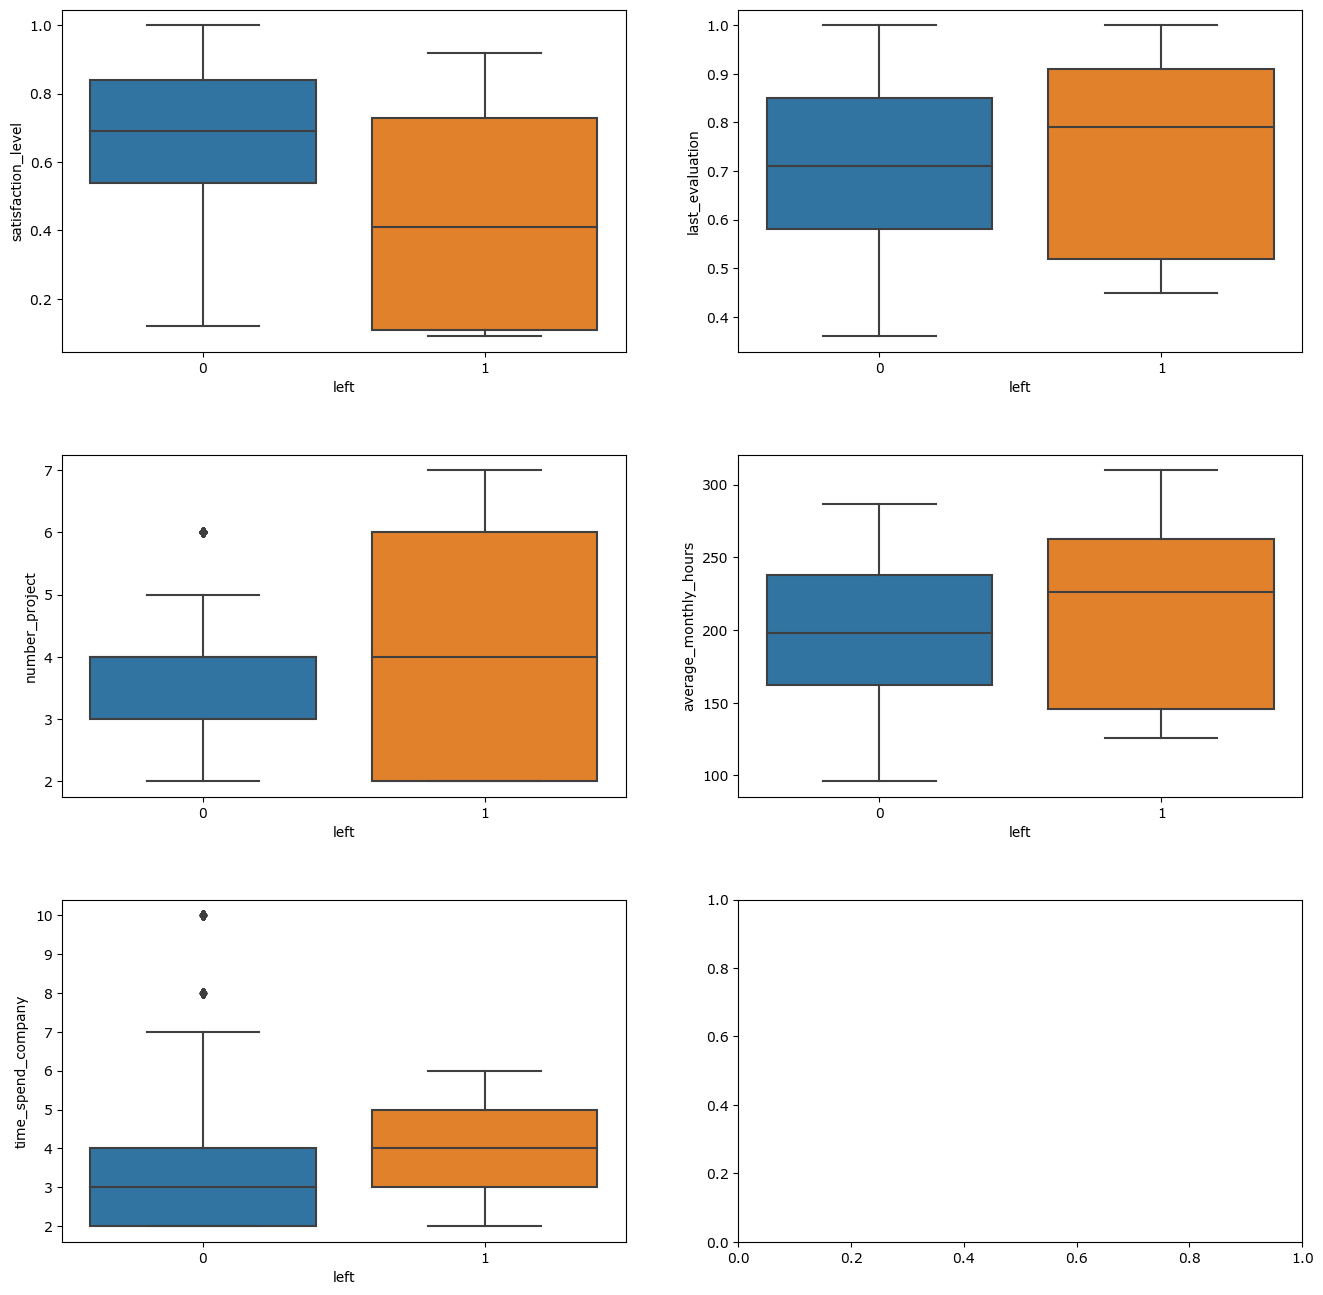

In [17]:
#CHECKING FOR THE REST OF THE COLUMNS INDIVIDUALLY
plt.subplots(figsize=(16,16), nrows=3, ncols=2)
plt.subplots_adjust(hspace=0.3)

for i in range(len(_BOXPLOT_COLUMNS)):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=df['left'], y=df[_BOXPLOT_COLUMNS[i]])
    
plt.show()

*The only visible one is the satisfaction level, which is pretty obvious in the first place. However it is not decided to include it, since the satisfaction level is obtained by survey, hence might not be objective.* ***The bigger question is, what would cause lower satisfaction level in the first place.***

<AxesSubplot: xlabel='left', ylabel='satisfaction_level'>

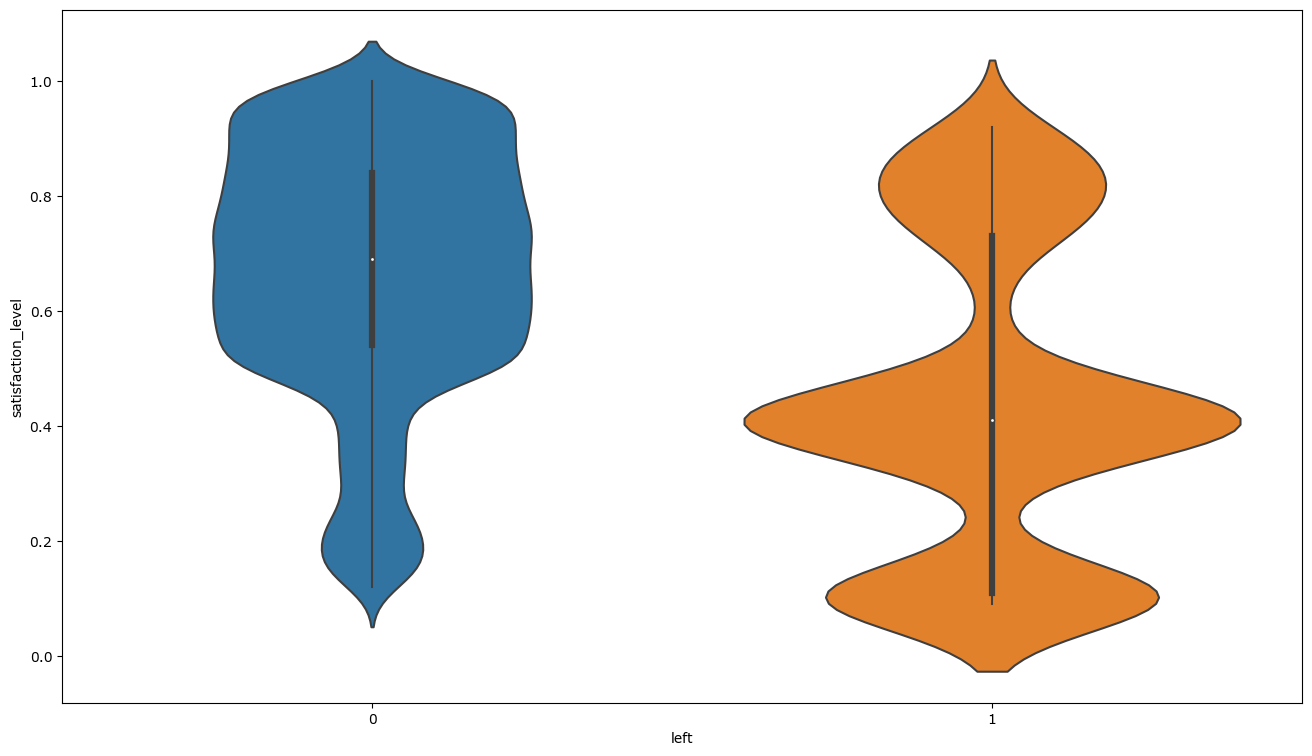

In [18]:
#DISTRIBUTION OF SATISFACTION LEVEL SEPARATED BY WHETHER THE EMPLOYEE LEFT OR STAYED
fig, ax = plt.subplots(figsize=(16,9))

sns.violinplot(df,y='satisfaction_level', x='left')

<AxesSubplot: xlabel='left', ylabel='salary'>

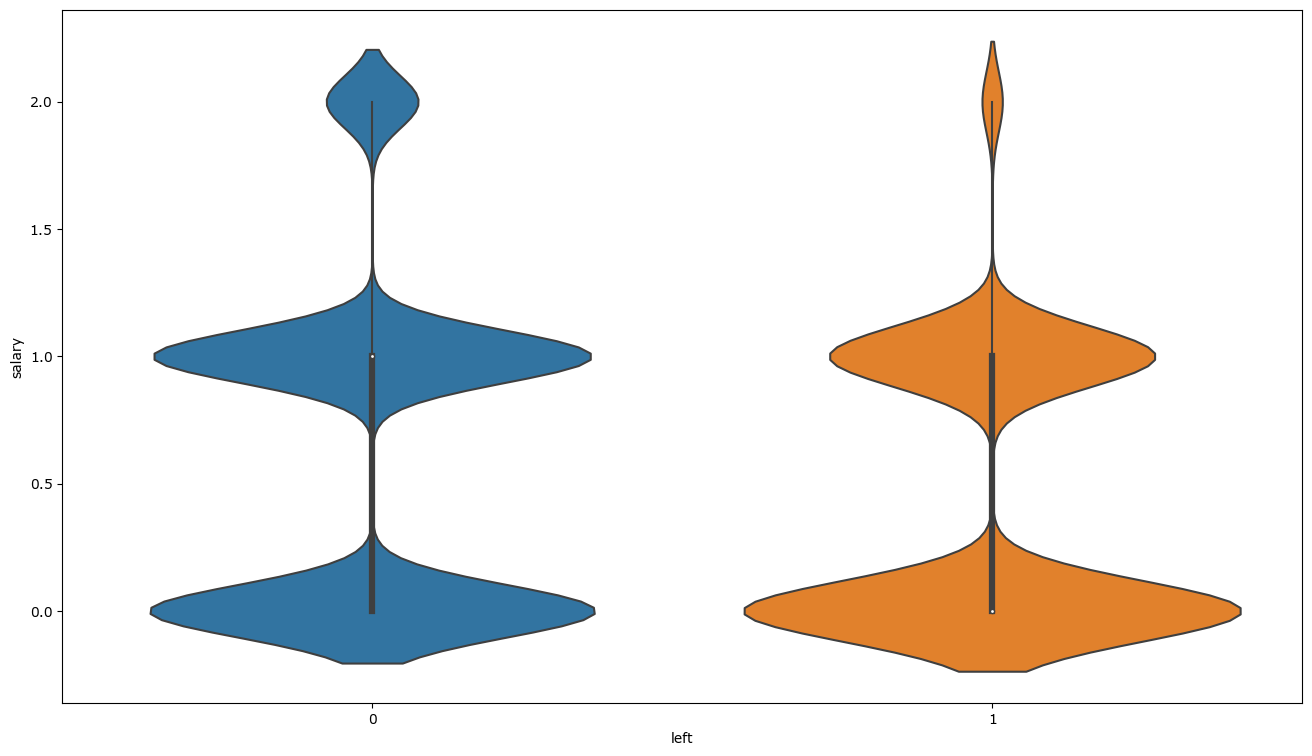

In [51]:
#CHECKING TO SEE IF SALARY PLAYS A BIG ROLE
fig, ax = plt.subplots(figsize=(16,9))

sns.violinplot(df,y='salary', x='left')

*As the plot above shows, the distribution of salary levels among those who left isn't skewed, it is almost identical to the overall distribution of all employees. There might be another condition that goes along with it to affect the outcome.*

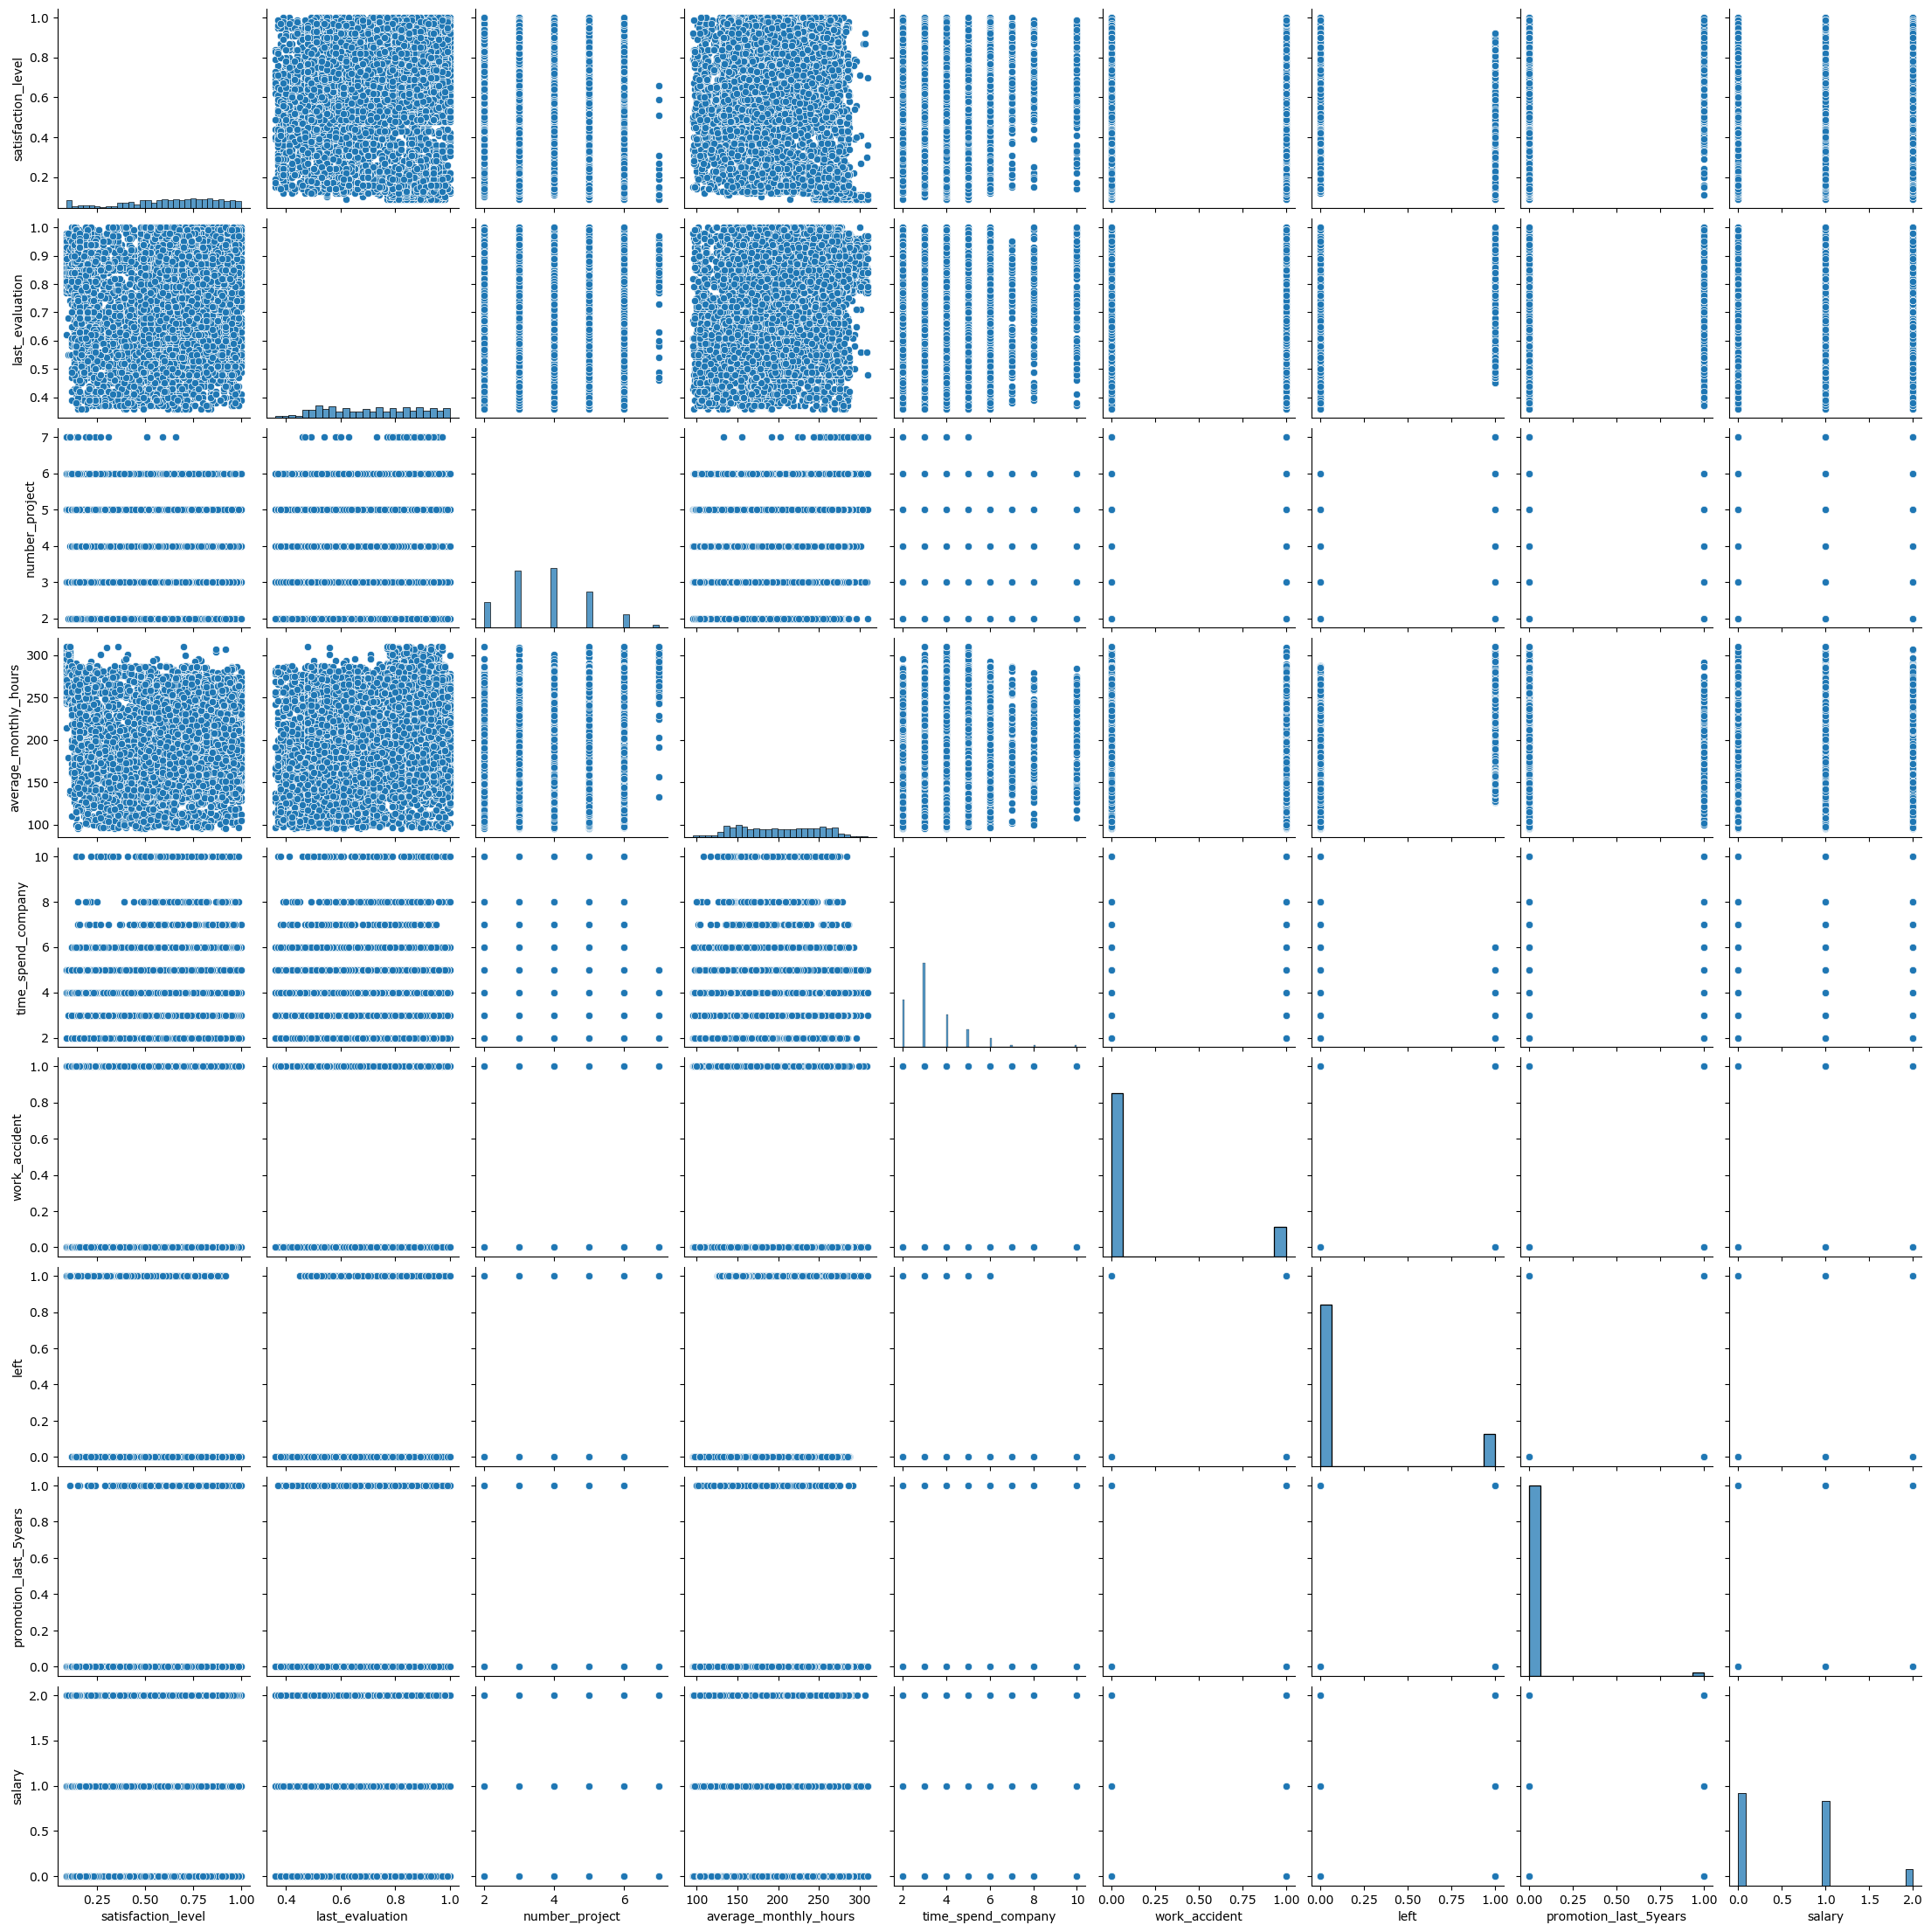

In [19]:
#CHECK FOR VISIBLE CORRELATION ON THE REMAINING FEATURES
sns.pairplot(df.drop(columns=['department']))

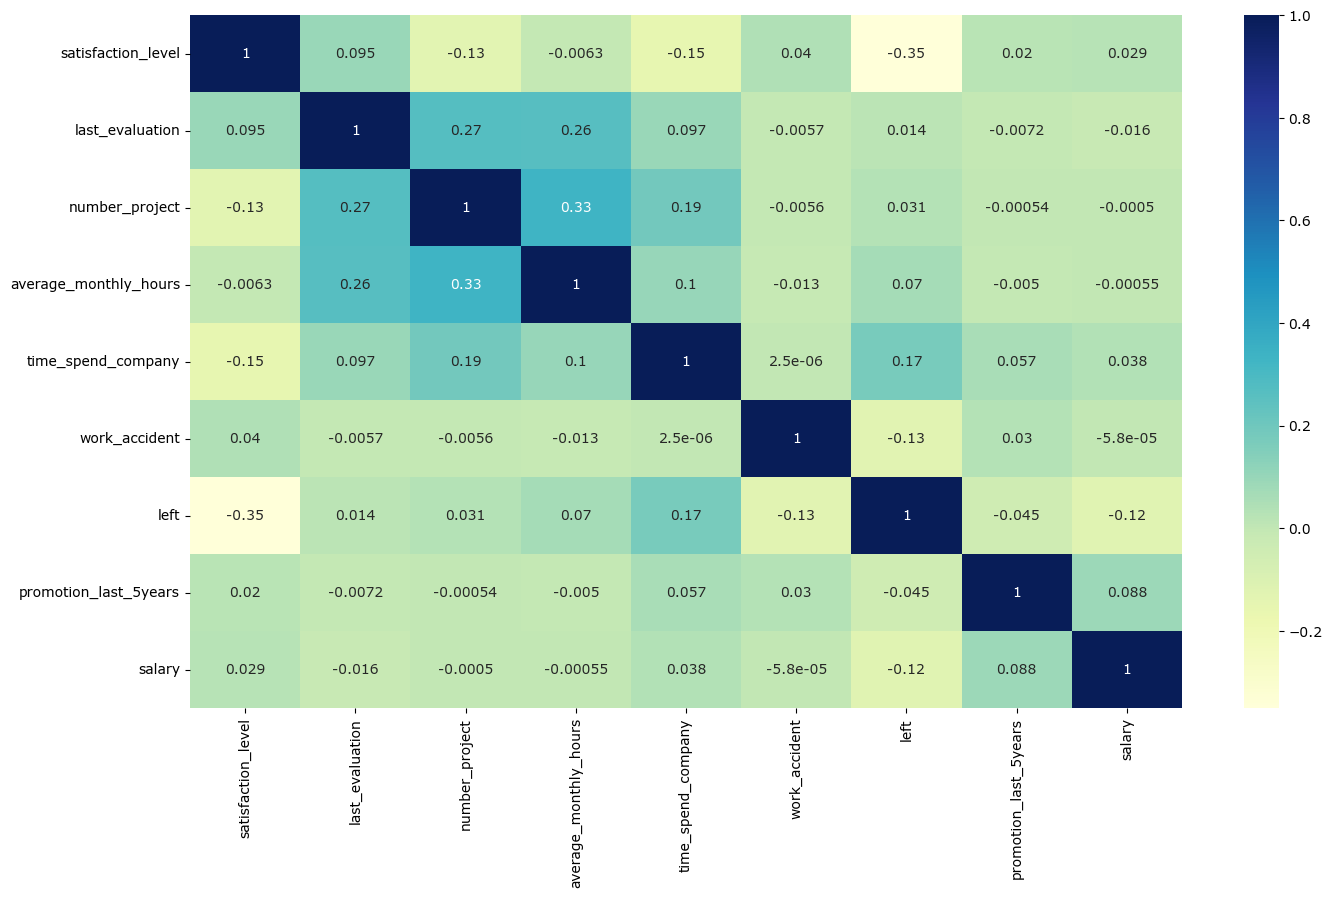

                 feature        VIF
0     satisfaction_level   6.781647
1        last_evaluation  18.766941
2         number_project  13.543620
3  average_monthly_hours  17.938810
4     time_spend_company   7.128101
5          work_accident   1.181756
6  promotion_last_5years   1.029690
7                 salary   1.890486


In [20]:
#CHECKING FOR MULTICOLINEARITY

#HEATMAP FOR CORRELATION COEFFICIENTS
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(df.drop(columns=['department']).corr(), cmap="YlGnBu", annot=True)

plt.show()


#CHECK VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.drop(columns=['department', 'left']).columns

vif_data["VIF"] = [variance_inflation_factor(df.drop(columns=['department', 'left']).values, i)
                          for i in range(len(df.drop(columns=['department', 'left']).columns))]
  
print(vif_data)

*The VIF values and correlation coefficients show that there is a low level of positive correlation between last_evaluation, number_project, and average_monthly_hours. It will be better to combine the average hours and projects total to calculate average monthly hours per project*

In [21]:
df['avg_hours_per_proj_m'] = df.apply(lambda x: x['average_monthly_hours'] / x['number_project'], axis=1)

In [65]:
#DECLARE CHOSEN FEATURES
_FEATURES = ['satisfaction_level', 'last_evaluation',
            'time_spend_company', 'work_accident',
            'promotion_last_5years', 'salary',
            'avg_hours_per_proj_m', 'left']

df_final = df[_FEATURES]

df_final['left'].value_counts()

0    10000
1     1991
Name: left, dtype: int64

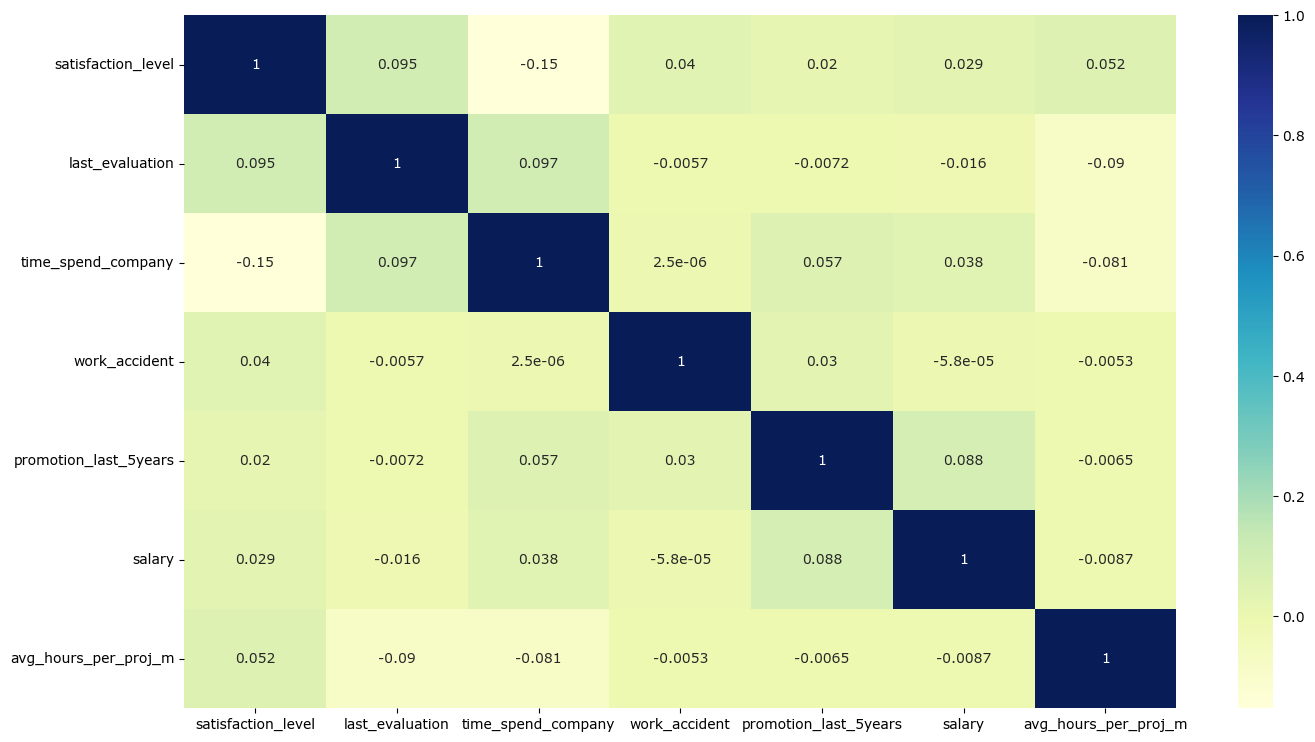

In [55]:
#FINAL CHECK FOR FEATURES INDEPENDENCE
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(df_final.drop(columns='left').corr(), cmap="YlGnBu", annot=True)
plt.show()

The outcome derived from the observation includes:
- those overworked will be more likely to resign, this can be attributed to having to handle multiple projects at once
- those who had been with the company for more than 6 years tend to stay
- those who were of higher positions tend to stay longer
- satisfaction level is gathered through survey, might not be an objective value, and is definitely influenced by other factors

## **CONSTRUCT & EXECUTE**

There will be 2 models to be constructed, logistic regression and a random forest classifier (RFC). The RFC wil then be compared to one fit with the extreme gradient boosting. For logistic regression, having satisfaction_level excluded will also be considered.

Optimum models' scoring is still optional, depending on what is more important. Recall would be preferred to reduce resignation, however it might also lead to waste of resources (monetary and time) spent investigating them. Precision would be the other way around. The models tuning will be done on f1-score to take both into account, compared to recall since prevention is the objective.

### *PREPARING NECESSARY TRAINING DATA AND FUNCTIONS*

In [144]:
x = df_final.drop(columns='left')
y = df_final['left']

x = StandardScaler().fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y ,test_size=0.25, random_state=69420)


In [153]:
#GENERAL FUNCTION FOR GRID SEARCH
def grid(method, parameters, score, x, y):
    
    model = GridSearchCV(method, 
                   param_grid = parameters, 
                   scoring=score,       
                   cv=5, n_jobs = -1)

    model.fit(x,y)

    print(f"Tuned Hyperparameters : {model.best_params_}")
    print(f"{score} : {model.best_score_}")

    return model.best_estimator_

In [223]:
#FUNCTION TO PLOT PRC (GIVEN THAT THE OUTCOME PROPORTION IS NOT BALANCED, INSPECTING PRC WOULD BE BETTER)
def _plots(model, x_t):
    # predict probabilities
    probs = model.predict_proba(x_t)
    preds = probs[:,1]

    # calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc = average_precision_score(y_test, preds)

    # plot subplots
    fig, ax = plt.subplots(figsize=(16, 9))

    # Precision-Recall Curve subplot
    ax.plot(recall, precision, color='blue', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall curve')
    ax.legend(loc="lower right")

    plt.show()

### *LOGISTIC REGRESSION*

In [154]:
parameters = { 
        'C': np.logspace(-4,4,30)
}

lg_model_f1 = grid(LogisticRegression(class_weight='balanced'), parameters, 'f1', x_train, y_train)

y_pred = lg_model_f1.predict(x_test)
print("\nTesting result (f1 score):")
print(classification_report(y_test, y_pred))

lg_model_rec = grid(LogisticRegression(class_weight='balanced'), parameters, 'recall', x_train, y_train)

y_pred = lg_model_rec.predict(x_test)
print("\nTesting result (recall):")
print(classification_report(y_test, y_pred))

Tuned Hyperparameters : {'C': 0.7278953843983146}
f1 : 0.5433670696809738

Testing result (f1 score):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2500
           1       0.41      0.82      0.55       498

    accuracy                           0.77      2998
   macro avg       0.68      0.79      0.70      2998
weighted avg       0.87      0.77      0.80      2998

Tuned Hyperparameters : {'C': 0.20433597178569418}
recall : 0.8224865884043007

Testing result (recall):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2500
           1       0.41      0.82      0.55       498

    accuracy                           0.77      2998
   macro avg       0.68      0.79      0.70      2998
weighted avg       0.87      0.77      0.80      2998



*Even with different parameters, they perform almost identically*

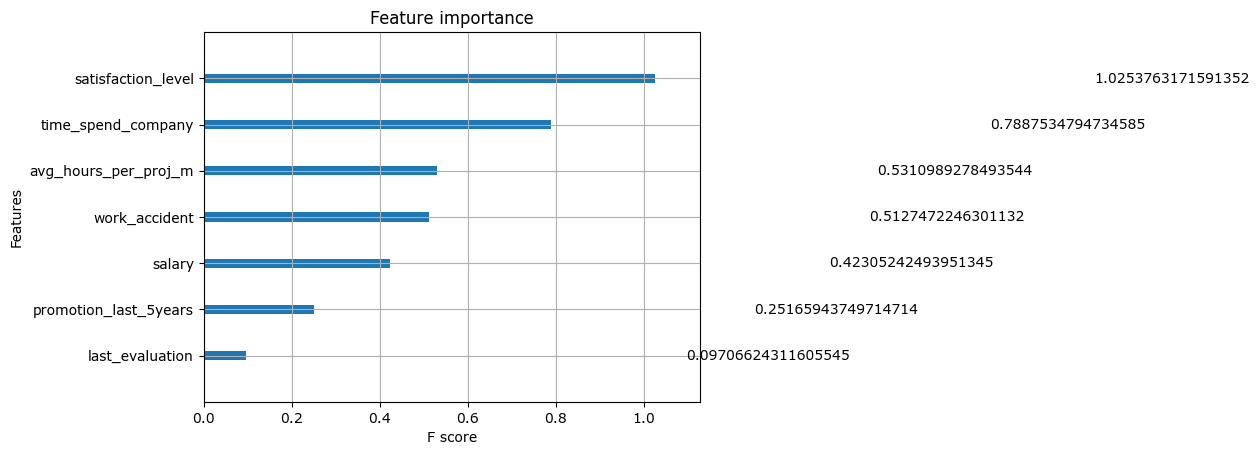

In [155]:
#CHECK WHICH FEATURE HAS THE HIGHEST COEFFICIENT
coefficients = pd.DataFrame({"feature": df_final.drop(columns='left').columns, "coefficient": abs(lg_model_f1.coef_[0])})
coefficients = coefficients.sort_values(by=["coefficient"], ascending=False)

plot_importance(dict(zip(coefficients['feature'], coefficients['coefficient'])))

plt.show()

*As expected, satisfaction_level affects the prediction the most, but not significantly to the next highest coefficient*

In [142]:
#SEE THE DIFFERENCE IN EXCLUDING satisfaction_level
x2 = df_final.drop(columns=['satisfaction_level', 'left'])

x2 = StandardScaler().fit_transform(x2)

x_train2, x_test2, y_train, y_test = train_test_split(x2, y, stratify=y ,test_size=0.25, random_state=69420)

In [145]:
parameters = { 
        'C': np.logspace(-4,4,30)
}

lg_model_f1 = grid(LogisticRegression(class_weight='balanced'), parameters, 'f1', x_train2, y_train)

y_pred = lg_model_f1.predict(x_test2)
print("\nTesting result (f1 score):")
print(classification_report(y_test, y_pred))

lg_model_rec = grid(LogisticRegression(class_weight='balanced'), parameters, 'recall', x_train2, y_train)

y_pred = lg_model_rec.predict(x_test2)
print("\nTesting result (recall):")
print(classification_report(y_test, y_pred))

Tuned Hyperparameters : {'C': 9.236708571873866}
f1 : 0.4225423930961794

Testing result (f1 score):
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      2500
           1       0.30      0.70      0.42       498

    accuracy                           0.68      2998
   macro avg       0.61      0.69      0.60      2998
weighted avg       0.82      0.68      0.72      2998

Tuned Hyperparameters : {'C': 0.20433597178569418}
recall : 0.7072658301721623

Testing result (recall):
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      2500
           1       0.30      0.70      0.42       498

    accuracy                           0.68      2998
   macro avg       0.61      0.69      0.60      2998
weighted avg       0.82      0.68      0.72      2998



*As shown above, the models perform slightly worse when satisfaction level is excluded. That feature is proven to be important, when the answer is honest.*

## *Random Forest Classifier*

In [149]:
parameters = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 500]
}

rf_model_f1 = grid(RandomForestClassifier(class_weight='balanced'), parameters, 'f1', x_train, y_train)

y_pred = rf_model_f1.predict(x_test)
print("\nTesting result (f1 score):")
print(classification_report(y_test, y_pred))

rf_model_rec = grid(RandomForestClassifier(class_weight= 'balanced'), parameters, 'recall', x_train, y_train)

y_pred = rf_model_rec.predict(x_test)
print("\nTesting result (recall):")
print(classification_report(y_test, y_pred))

Tuned Hyperparameters : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
f1 : 0.9440819693788614

Testing result (f1 score):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2500
           1       0.98      0.90      0.94       498

    accuracy                           0.98      2998
   macro avg       0.98      0.95      0.96      2998
weighted avg       0.98      0.98      0.98      2998

Tuned Hyperparameters : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
recall : 0.9163026643621917

Testing result (recall):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2500
           1       0.98      0.90      0.94       498

    accuracy                           0.98      2998
   macro avg       0.98      0.95      0.96      2998
weighted avg       0.98      0.98      0.98      2998



*Again, both models are identical in result. The more important point is that a random forest classifier performs significantly better than a logistic regression model. This is highly likely due to large proportion of the features are categorical.*

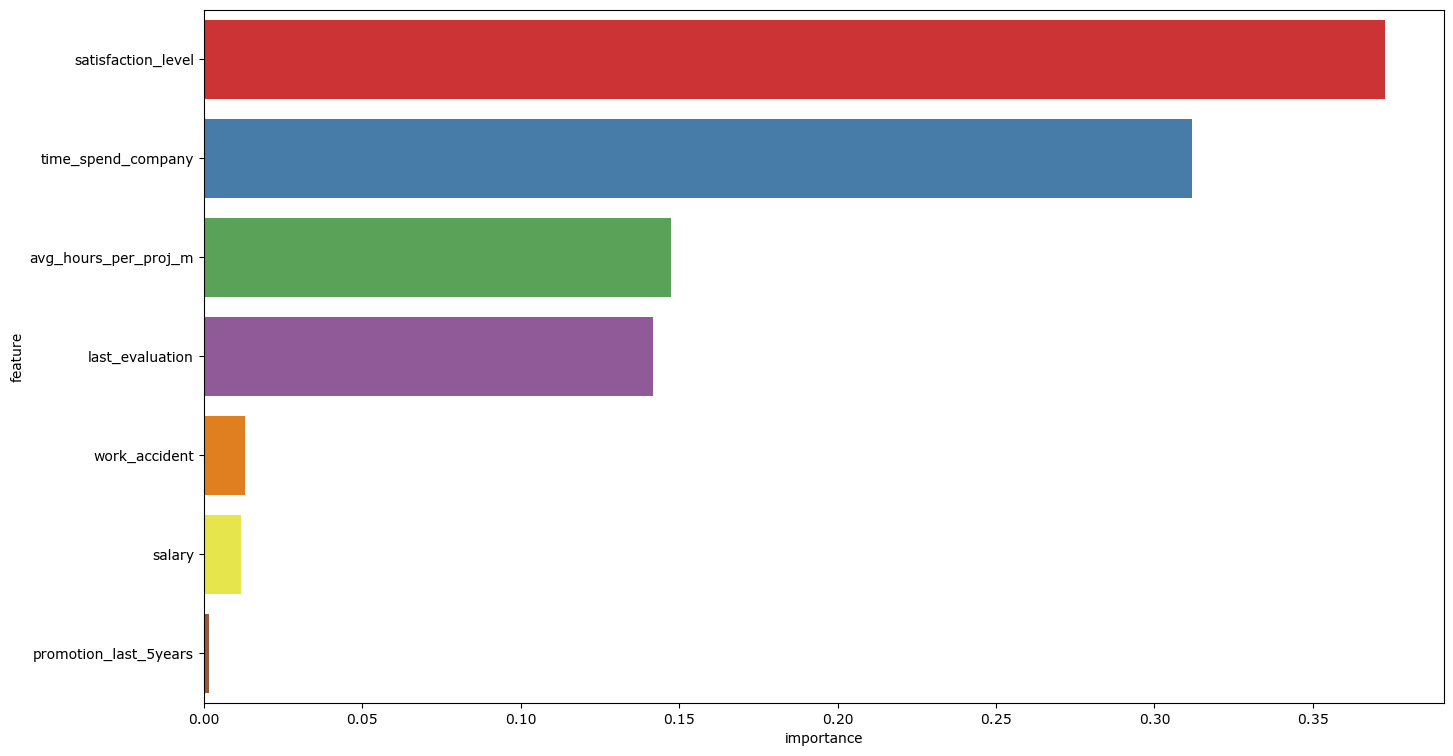

In [205]:
#CHECK WHICH FEATURE HAS THE HIGHEST IMPORTANCE
importance = pd.DataFrame({"feature": df_final.drop(columns='left').columns, "importance": abs(rf_model_f1.feature_importances_)})
importance = importance.sort_values(by=["importance"], ascending=False)


fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(importance, x = 'importance', y='feature', palette='Set1')

plt.show()

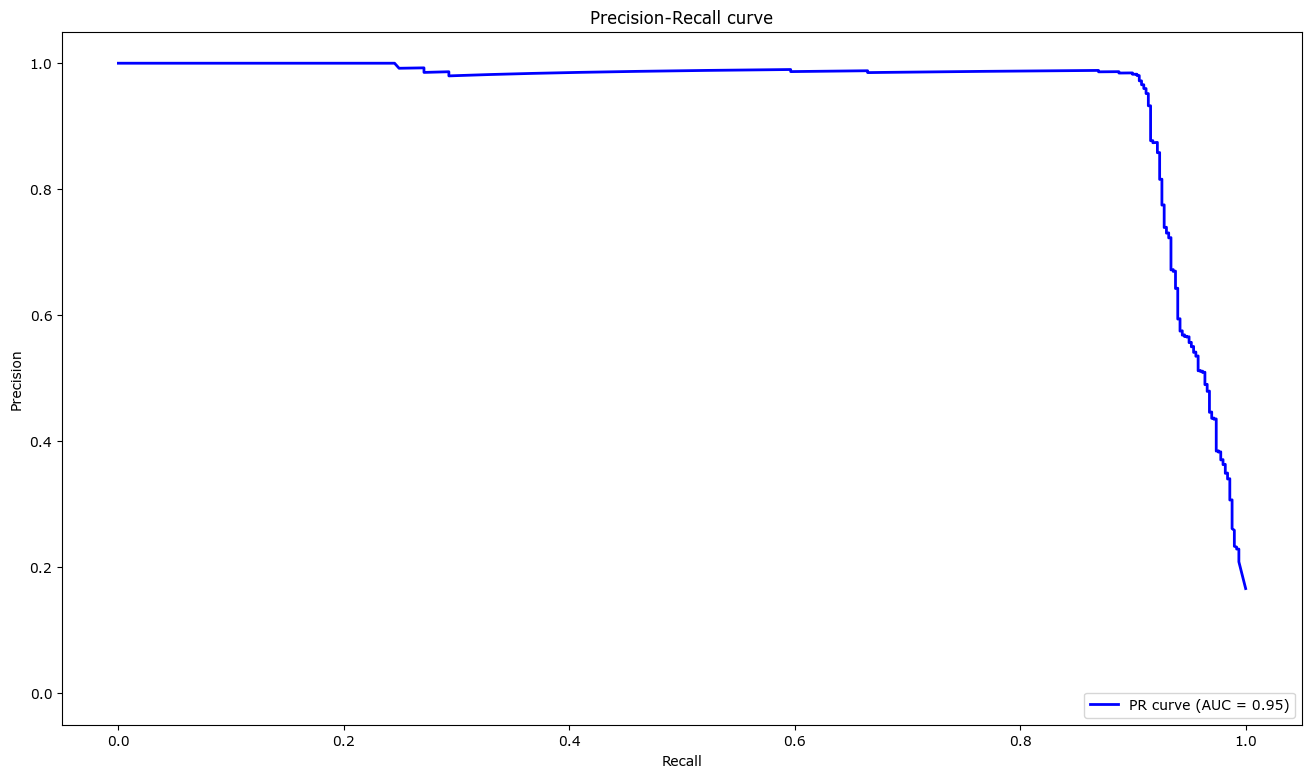

In [224]:
_plots(rf_model_f1,x_test)

## *EXTREME GRADIENT BOOSTING*

In [213]:
parameters = {
    'max_depth': [5,8,10,15],
    'min_child_weight': np.linspace(2,10,9),
    'learning_rate': np.linspace(0.01,0.2,10),
    'n_estimators': [90,100]
    }


xgb_model_f1 = grid(XGBClassifier(objective='binary:logistic'), parameters, 'f1', x_train, y_train)

y_pred = xgb_model_f1.predict(x_test)
print("\nTesting result (f1 score):")
print(classification_report(y_test, y_pred))

xgb_model_rec = grid(XGBClassifier(objective='binary:logistic'), parameters, 'recall', x_train, y_train)

y_pred = xgb_model_rec.predict(x_test)
print("\nTesting result (recall):")
print(classification_report(y_test, y_pred))

Tuned Hyperparameters : {'learning_rate': 0.09444444444444444, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 90}
f1 : 0.9431712905411913

Testing result (f1 score):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2500
           1       0.98      0.90      0.94       498

    accuracy                           0.98      2998
   macro avg       0.98      0.95      0.96      2998
weighted avg       0.98      0.98      0.98      2998

Tuned Hyperparameters : {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 90}
recall : 0.9156270341855401

Testing result (recall):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2500
           1       0.98      0.91      0.94       498

    accuracy                           0.98      2998
   macro avg       0.98      0.95      0.97      2998
weighted avg       0.98      0.98      0.98      2998



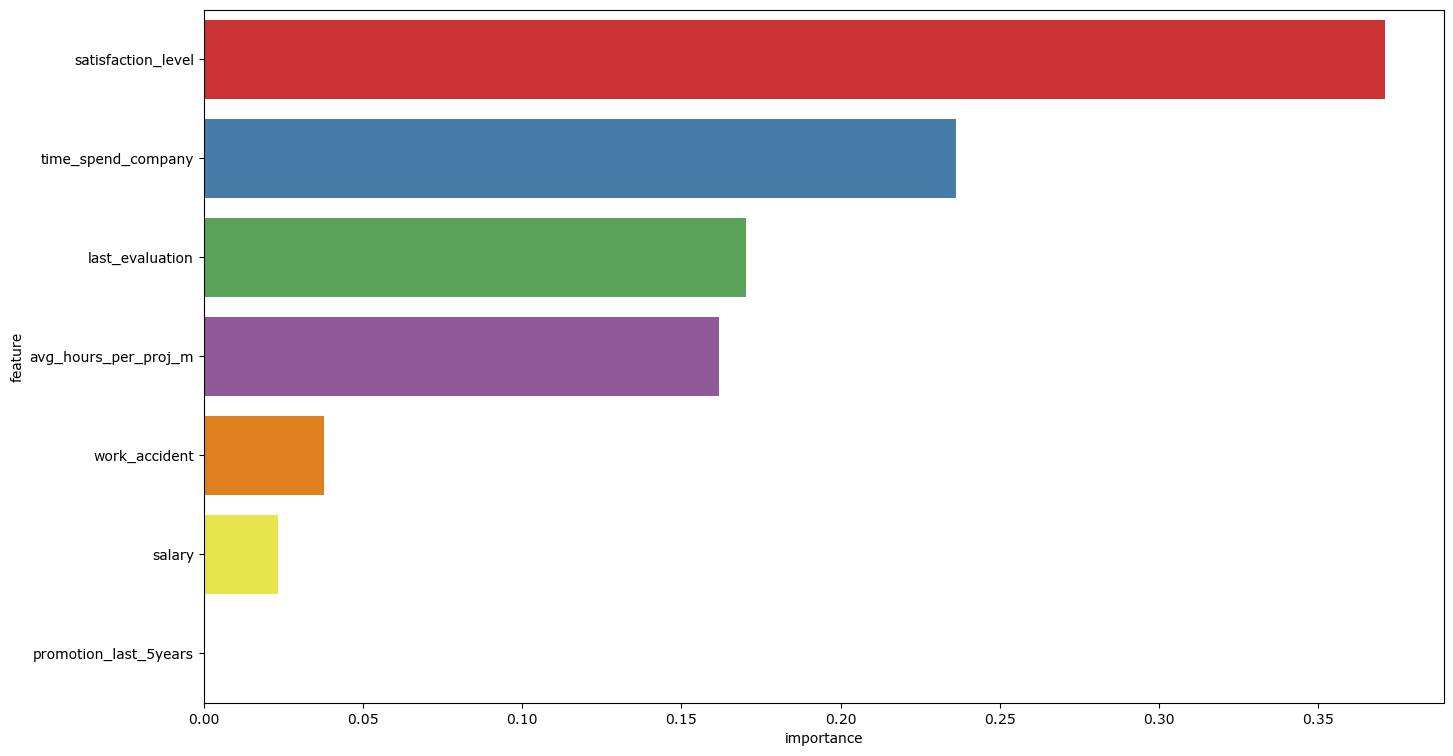

In [215]:
importance_xgb = pd.DataFrame({"feature": df_final.drop(columns='left').columns, "importance": abs(xgb_model_f1.feature_importances_)})
importance_xgb = importance_xgb.sort_values(by=["importance"], ascending=False)


fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(importance_xgb, x = 'importance', y='feature', palette='Set1')

plt.show()

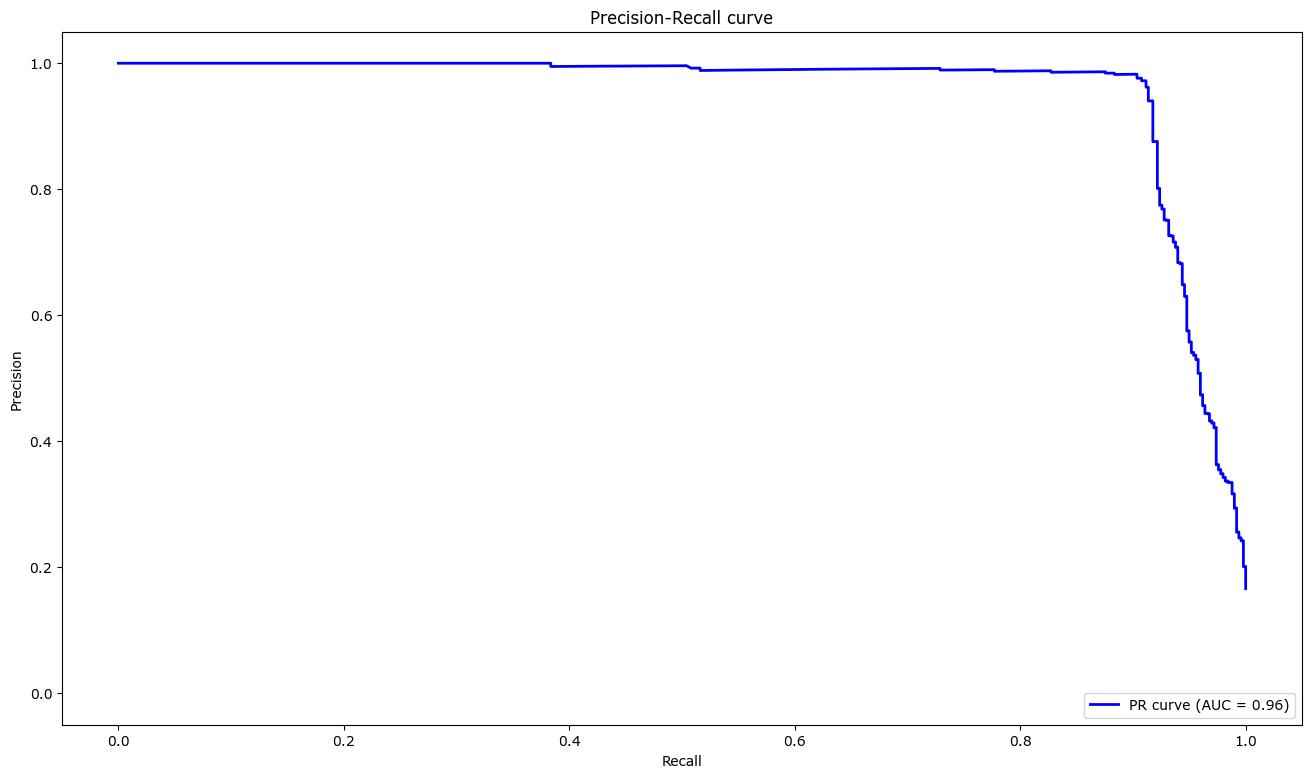

In [225]:
_plots(xgb_model_f1, x_test)

*Even with different feature importance, there is barely any difference in the performance between random forest and extreme gradient boosting. The only upside is miniscule difference of the PRC of the XGB model.*

## **CONCLUSION**

The best model to be used for predictions is either the RFC (random forest classifier) or the XGB (extreme gradient boosting) model, both performing similarly at ~96% f1 score, correctly predicting ~91% of those who ended up leaving the company. Both model relies the most on the satisfaction level, however as stated before, since it is a highly subjective value, it can cause a lot of inaccuracy depending on the employee. As to  the factors that lead to higher satisfaction level, they can be derived from the next most important features, such as the number of years working for the company (with those working for more than 6 years to be more likely to stay), and how overworked the employees are.

**Recommendation:**
- create a working environment that promotoes work-life balance
- establish a cap on concurrent projects assignment
- improve reward system based on performance, in order to increase incentive achieving higher evaluation score as well
- only take the outcome from the predictions as a possibility and investigate further, since immediately assuming it to be true might lead to unintended consequences

**Improving data gathering:**
- provide numerical values to salary, to be able to see if salaries based on department matters
- provide a distinction on the circumstances of the employees who left the company (resignation or lay off)
- provide more data on those who are not with the company anymore